In [145]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import math

In [2]:
all_line=gpd.read_file(r"./full_progression_1219_frontline.shp")

In [3]:
def line_segment(profile):
    '''
    takes one linestring and returns multilinestring with all segments of the line
    argument:
    profile is one shapely linestring geometry
    return:
    shapely multilinestring 
    '''
    import shapely.geometry as geom
    import geopandas as gpd
    splitted = geom.MultiLineString([geom.LineString([profile.coords[i], profile.coords[i+1]]) for i in range(len(profile.coords)-1)])
    return splitted

apply the line_segment function to each row to convert the long linestring of each daily frontline to multilingstring of line segments

In [4]:
#geom_convert=all_line.geometry.apply(line_segment) #when dimension is reduced, axis=1 applys to each row
#all_line.geometry=geom_convert
#all_line.to_file(r"./full_progression_1219_frontline_seg.shp")

explode multi-linestring; each line segment will be one observation

In [33]:
#new_all_line=all_line.explode()
#new_all_line=new_all_line.rename_axis(['old_id','new_id']).reset_index()
new_all_line.to_file(r"./full_progression_1219_frontline_segment.shp")

### Find Nearest Progression Line
For each line segment, find the nearest/most possible line segment in the next day as its new location, calculate the displacement as the speed and the direction

In [52]:
#simplify the dataset
select_col=['old_id', 'new_id', 'FID_Full_p', 'Name', 'gridcode', 'BurnedArea','Year', 'time_perce', 'front_len','geometry']
spread_fire=new_all_line[select_col]

In [47]:
def mid_dist(line1,line2):
    '''
    takes two linestrings and calculate their mid-point distance
    '''
    p1=line1.centroid
    dist=p1.distance(line2.centroid)
    return dist

In [191]:
def middle_angle(line1,line2):
    '''
    takes two linestrings and calculate the slope of the line connecting their mid-points
    the direction is based on line1
    return angle value in degrees (ranges from -180(0)-180, 0 degree indicates east, 180 indicates west, 90 is north,-90 is south)
    '''
    
    p1=line1.centroid
    p2=line2.centroid
    #use math package
    dy=p2.coords[0][1]-p1.coords[0][1]
    dx=p2.coords[0][0]-p1.coords[0][0]
    angle_mid=math.degrees(math.atan2(dy, dx)) #get radiance and convert to degree

    #use numpy
    #connecting=shapely.geometry.LineString([p1,p2])
    #seg = np.array(connecting)
    #seg = seg[1] - seg[0]
    #angle_mid = np.angle(complex(*(seg)), deg=True)
    
    return angle_mid

In [179]:
a=spread_fire.geometry[0]
b=spread_fire.geometry[1]
print('min dist: ',a.distance(b))
print('Hausdorff dist: ',a.hausdorff_distance(b))
print('middle point dist: ',mid_dist(a,b))
print('middle point angle',mid_angle(a,b))


min dist:  0.0
Hausforff dist:  740.9284806814081
middle point dist:  457.8505255169644
middle point angle 133.6015212726426


In [45]:
print(a.wkt)
print(a.centroid)
ax=

LINESTRING (121338.4572297199 -55379.56288734113, 121034.5822171743 -55381.01092468918)
POINT (121186.5197234471 -55380.28690601516)


In [277]:
def calculate_nearest(line, search,from_line=True):
    '''
    
    takes one lingstring geometry and a set of other linestrings as gpd
    calculates the hausdorff distance to find the nearest element, return the hausdorff distance and midpoint distance
    
    pachages:
    numpy, shapely, geopandas
    argument:
    line: the line to be used to find out its nearest element
    search: a set of geometries as geodataframe
    from_line: boolean; True: calculate direction/angle from input line to nearest; 
                        False: calculate direction from nearest to current
    
    return
    hausdorff distance and midpoint distance
    '''
    
    hd_dis_list=[]
    #md_dis_list=[]
    for row_shape in search.geometry:
        hd_dis_list.append(line.hausdorff_distance(row_shape))
        #md_dis_list.append(mid_dist(line,row_shape))
    hd_dis_list=np.array(hd_dis_list)
    hd_dis=min(hd_dis_list)
    #drop the original index from gpd to use argmin to find the nearest geometry
    nearest=search.geometry.reset_index(drop=True)[np.argmin(hd_dis_list)]
    md_dis=mid_dist(line,nearest)
    if from_line:
        md_ang=middle_angle(line,nearest)
    else:
        md_ang=middle_angle(nearest,line)
    #print('min midpoint: ',min(np.array(md_dis_list)))
    #print('min hausdorff: ',line.hausdorff_distance(search.geometry.reset_index(drop=True)[np.argmin(hd_dis_list)]))
    #return search.geometry.reset_index(drop=True)[np.argmin(hd_dis_list)],search.geometry.reset_index(drop=True)[np.argmin(md_dis_list)]
    
    return hd_dis,md_dis,md_ang
        
    
    

In [181]:
data.columns

Index(['old_id', 'new_id', 'FID_Full_p', 'Name', 'gridcode', 'BurnedArea',
       'Year', 'time_perce', 'front_len', 'geometry', 'hd_dist', 'mid_dist'],
      dtype='object')

### Calculate speed and direction to the next day for current fireline

In [197]:
#gpd provide distance (min dist) and hausdorff_distance (the max of all min dist between all pairs of points), 
#use hausdorff as min dist can be misleading and not sensitive to object posision
fires=spread_fire.Name.unique()
spread_dataset=pd.DataFrame()
for fire in fires:
    data=spread_fire.loc[spread_fire['Name']==fire,:].copy()
    data['hd_dist']=0
    data['mid_dist']=0
    data['mid_dir']=-999
    days=data.gridcode.unique()
    duration=len(days)
    if duration<=1:
        data['hd_dist']=0
        data['mid_dist']=0
        data['mid_dir']=-999
    else:
        haus=[]
        middle=[]
        mid_angle=[]
        error_saver=[]
        for ind,row in data.iterrows():
            try:
                if row.gridcode==max(days):
                    haus.append(0)
                    middle.append(0)
                    mid_angle.append(-999)
                else:
                    line=row.geometry
                    search=data.loc[data['gridcode']==row.gridcode+1,:].copy()
                    hd_dis,md_dis,md_ang=calculate_nearest(line, search)
                    haus.append(hd_dis)
                    middle.append(md_dis)
                    mid_angle.append(md_ang)
            except:
                haus.append(0)
                middle.append(0)
                mid_angle.append(-999)
                error_saver.append('error occurred at: '+fire+'  '+str(row.gridcode)+'  '+str(row.old_id)+'  '+str(row.new_id))
                print('error occurred at: ',fire,row.gridcode,row.old_id,row.new_id)
        data['hd_dist']=haus
        data['mid_dist']=middle
        data['mid_dir']=mid_angle
    spread_dataset=pd.concat([spread_dataset,data],axis=0)
    #print('complete calculation for: ',fire)
        
        

error occurred at:  Aspen 222 4036 0
error occurred at:  Aspen 222 4038 0
error occurred at:  Empire 258 15547 0
error occurred at:  Empire 258 15548 0
error occurred at:  Empire 258 15584 0
error occurred at:  Empire 258 15585 0
error occurred at:  Empire 258 15629 0
error occurred at:  Empire 258 15630 0
error occurred at:  Empire 258 15654 0
error occurred at:  Empire 262 16144 0
error occurred at:  Empire 262 16151 0
error occurred at:  Empire 264 16320 0
error occurred at:  Empire 264 16320 1
error occurred at:  Empire 266 16430 0
error occurred at:  Empire 266 16445 0
error occurred at:  Empire 266 16446 0
error occurred at:  Empire 266 16446 1
error occurred at:  Empire 271 16513 0
error occurred at:  Empire 271 16514 0
error occurred at:  Empire 271 16515 0
error occurred at:  Empire 271 16516 0
error occurred at:  Empire 274 16538 0
error occurred at:  Empire 274 16541 0
error occurred at:  Empire 274 16550 0
error occurred at:  Empire 284 16777 0
error occurred at:  Empire 28

### Modify fire spread with errors
Aspen, Empire,Creekstf

Aspen

In [288]:
backup=spread_dataset

In [225]:
data=spread_dataset.loc[spread_dataset['Name']=='Aspen',:].copy()

In [227]:
select=data.loc[data['gridcode']==222,:].copy()

In [231]:
days=data.gridcode.unique()

In [248]:
for ind, row in select.iterrows():
    line=row.geometry
    day_ind=np.where(days==222)[0][0]
    search=data.loc[data['gridcode']==days[day_ind+1],:].copy()
    hd_dis,md_dis,md_ang=calculate_nearest(line, search)
    spread_dataset.loc[ind,'hd_dist']=hd_dis/(days[day_ind+1]-222)
    spread_dataset.loc[ind,'mid_dist']=md_dis/(days[day_ind+1]-222)
    spread_dataset.loc[ind,'mid_dir']=md_ang

Creekstf

In [260]:
data=spread_dataset.loc[spread_dataset['Name']=='Creekstf',:].copy()
select=data.loc[data['gridcode']==268,:].copy()

In [261]:
days=data.gridcode.unique()

In [262]:
for ind, row in select.iterrows():
    line=row.geometry
    day_ind=np.where(days==268)[0][0]
    search=data.loc[data['gridcode']==days[day_ind+1],:].copy()
    hd_dis,md_dis,md_ang=calculate_nearest(line, search)
    spread_dataset.loc[ind,'hd_dist']=hd_dis/(days[day_ind+1]-268)
    spread_dataset.loc[ind,'mid_dist']=md_dis/(days[day_ind+1]-268)
    spread_dataset.loc[ind,'mid_dir']=md_ang

Empire

In [264]:
data=spread_dataset.loc[spread_dataset['Name']=='Empire',:].copy()

In [268]:
missing=[258, 262, 264, 266, 271,274,284]

In [269]:
select=data.loc[data['gridcode'].isin(missing),:].copy()

In [270]:
days=data.gridcode.unique()

In [275]:
for ind, row in select.iterrows():
    line=row.geometry
    day_ind=np.where(days==row.gridcode)[0][0]
    search=data.loc[data['gridcode']==days[day_ind+1],:].copy()
    hd_dis,md_dis,md_ang=calculate_nearest(line, search)
    spread_dataset.loc[ind,'hd_dist']=hd_dis/(days[day_ind+1]-row.gridcode)
    spread_dataset.loc[ind,'mid_dist']=md_dis/(days[day_ind+1]-row.gridcode)
    spread_dataset.loc[ind,'mid_dir']=md_ang

### Calculate speed and direction from the previous day for current fireline

In [292]:
#spread_fire=spread_dataset
#gpd provide distance (min dist) and hausdorff_distance (the max of all min dist between all pairs of points), 
#use hausdorff as min dist can be misleading and not sensitive to object posision
fires=spread_fire.Name.unique()
spread_dataset=pd.DataFrame()
for fire in fires:
    data=spread_fire.loc[spread_fire['Name']==fire,:].copy()
    data['hd_dist_pre']=0
    data['mid_dist_pre']=0
    data['mid_dir_pre']=-999
    days=data.gridcode.unique()
    duration=len(days)
    if duration<=1:
        data['hd_dist_pre']=0
        data['mid_dist_pre']=0
        data['mid_dir_pre']=-999
    else:
        haus=[]
        middle=[]
        mid_angle=[]
        error_saver=[]
        for ind,row in data.iterrows():
            try:
                if row.gridcode==min(days):
                    haus.append(0)
                    middle.append(0)
                    mid_angle.append(-999)
                else:
                    line=row.geometry
                    day_ind=np.where(days==row.gridcode)[0][0]
                    search=data.loc[data['gridcode']==days[day_ind-1],:].copy()
                    hd_dis,md_dis,md_ang=calculate_nearest(line, search,from_line=False)
                    haus.append(hd_dis/(row.gridcode-days[day_ind-1]))
                    middle.append(md_dis/(row.gridcode-days[day_ind-1]))
                    mid_angle.append(md_ang)
            except:
                haus.append(0)
                middle.append(0)
                mid_angle.append(-999)
                error_saver.append('error occurred at: '+fire+'  '+str(row.gridcode)+'  '+str(row.old_id)+'  '+str(row.new_id))
                print('error occurred at: ',fire,row.gridcode,row.old_id,row.new_id)
        data['hd_dist_pre']=haus
        data['mid_dist_pre']=middle
        data['mid_dir_pre']=mid_angle
    spread_dataset=pd.concat([spread_dataset,data],axis=0)
    #print('complete calculation for: ',fire)
        
        

In [294]:
#spread_dataset
spread_dataset.to_file(r"./full_progression_1219_fireline_spread.shp")

### Example Maps

In [302]:
spread_dataset.columns

Index(['old_id', 'new_id', 'FID_Full_p', 'Name', 'gridcode', 'BurnedArea',
       'Year', 'time_perce', 'front_len', 'geometry', 'hd_dist', 'mid_dist',
       'mid_dir', 'hd_dist_pre', 'mid_dist_pre', 'mid_dir_pre'],
      dtype='object')

In [303]:
backup=spread_dataset
backup.loc[backup['mid_dir']==-999,'mid_dir']=np.nan
backup.loc[backup['mid_dir_pre']==-999,'mid_dir_pre']=np.nan

In [304]:
pier=backup.loc[backup['Name']=='Pier',:]
lion=backup.loc[backup['Name']=='Lion',:]

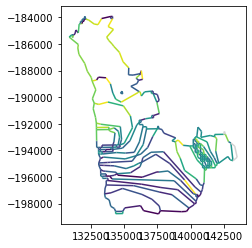

In [305]:
lion.plot(column='mid_dir',missing_kwds={'color': 'lightgrey'})

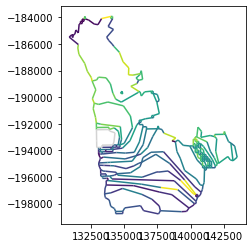

In [306]:
lion.plot(column='mid_dir_pre',missing_kwds={'color': 'lightgrey'})